In [1]:
import seaborn as sns
import matplotlib.style as style
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


%matplotlib inline
style.use('fivethirtyeight')


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        # use first and second column in the dataset
        a = dataset[i:(i+look_back), 0:3]
        dataX.append(a)
        # the output is at the third column of the dataset
        dataY.append(dataset[i + look_back, 3])
    return np.array(dataX), np.array(dataY)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
dataframe_trainset = read_csv(
    '../dataset/different_cycle_train_test/train_FUDS_BJDST_US06.csv', header=0, index_col=0)

dataframe_testset = read_csv(
    '../dataset/different_cycle_train_test/test_DST.csv', header=0, index_col=0)

In [3]:
train_dataset = dataframe_trainset.values
X = train_dataset[:, :2]
# one hot encode the temperature
tempBinarizer = LabelBinarizer().fit(dataframe_trainset['Temp(C)'])
trainCategorical = tempBinarizer.transform(dataframe_trainset['Temp(C)'])
# concatenate the one hot features to V and I
X = np.hstack([X, trainCategorical])
Y = train_dataset[:, 3]


test_dataset = dataframe_testset.values
X_test = test_dataset[:, :2]
# one hot encode the temperature
tempBinarizer = LabelBinarizer().fit(dataframe_testset['Temp(C)'])
testCategorical = tempBinarizer.transform(dataframe_testset['Temp(C)'])
X_test = np.hstack([X_test, testCategorical])
Y_test = test_dataset[:, 3]

# reshape into X=t and Y=t+1
look_back = 15
feature = 3  # voltage and current and temp

trainX, trainY = create_dataset(train_dataset, look_back)
testX, testY = create_dataset(test_dataset, look_back)

In [4]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], feature))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], feature))

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, regularizers, BatchNormalization

from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l2

from keras.layers import Conv1D, Input, Add, Activation, Dropout, Multiply, Lambda, add, concatenate
from keras.initializers import TruncatedNormal
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.optimizers import Adam
from keras.layers import SimpleRNN
from time import time
import livelossplot
from clr_callback import CyclicLR

MIN_LR = 1e-7
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "triangular2"
NUM_EPOCHS = 96

TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])

clr = CyclicLR(
    mode=CLR_METHOD,
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=STEP_SIZE * (trainX.shape[0] // BATCH_SIZE))


plot_losses = livelossplot.PlotLossesKeras()

csv_logger = CSVLogger(
    filename='fcn_saved_models/training.log', separator=',', append=False)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=2, cooldown=10)

earlyStopping = EarlyStopping(
    monitor='val_loss', patience=30, verbose=2, mode='auto')

filepath = "fcn_saved_models/weights-improvement-{epoch:03d}-{val_loss:.6f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

callbacks_list = [plot_losses, clr]

Using TensorFlow backend.
/media/camaro/CODE_DATASET1/anaconda3/envs/soc/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv1D(n_filters, 3, padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling1D(2, strides=2)(layer_in)
    return layer_in

In [7]:
# define model input
visible = Input(shape=(look_back, feature))
# add residual module
layer = vgg_block(visible, 64, 3)
layer = vgg_block(layer, 128, 2)
layer = vgg_block(layer, 128, 2)


# out_conv = Conv1D(1, 1)(layer)
# out_conv = GlobalAveragePooling1D()(out_conv)
# out_conv = Activation('relu')(out_conv)
# model = Model(inputs=visible, outputs=out_conv)

out_dense = Flatten()(layer)
out_dense = Dense(1, kernel_initializer='he_uniform', activation='linear')(out_dense)
# create model
model = Model(inputs=visible, outputs=out_dense)
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            640       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 128)            24704     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 128)            49280     
__________

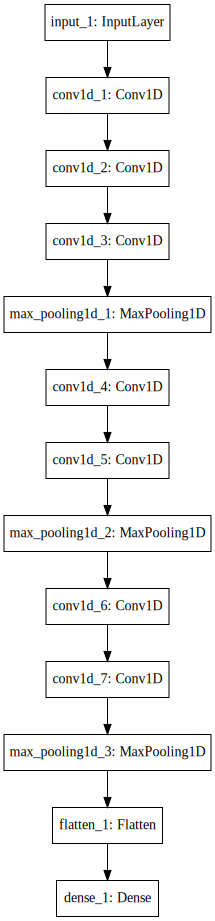

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

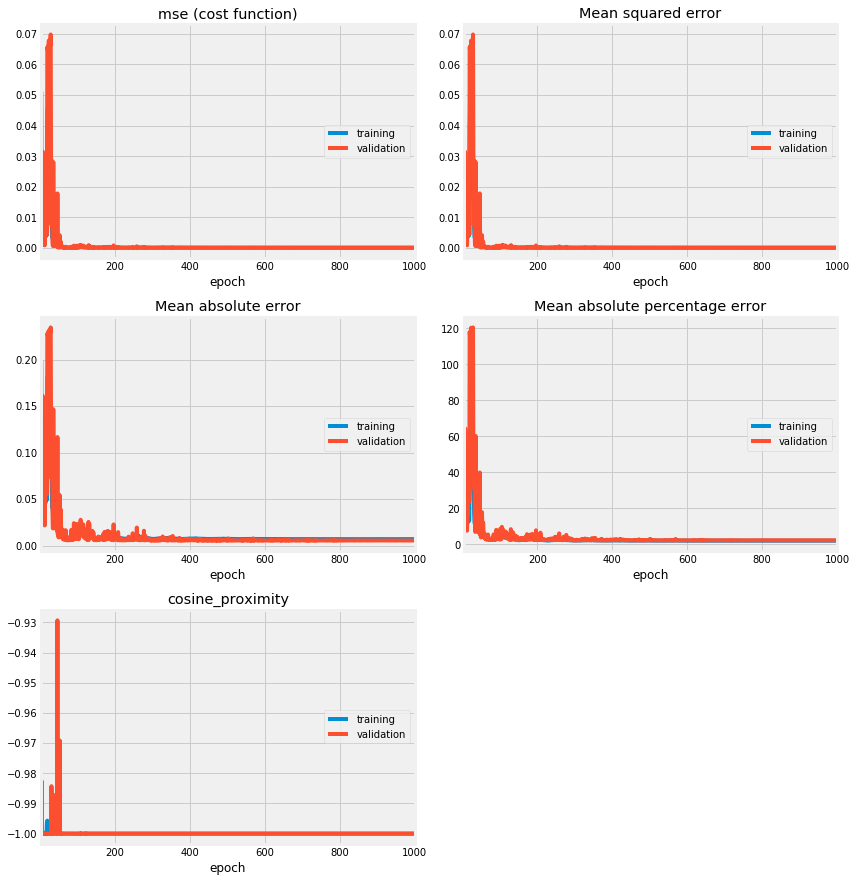

mse (cost function):
training   (min:    0.000, max:    0.055, cur:    0.000)
validation (min:    0.000, max:    0.070, cur:    0.000)

Mean squared error:
training   (min:    0.000, max:    0.055, cur:    0.000)
validation (min:    0.000, max:    0.070, cur:    0.000)

Mean absolute error:
training   (min:    0.007, max:    0.192, cur:    0.007)
validation (min:    0.005, max:    0.235, cur:    0.006)

Mean absolute percentage error:
training   (min:    1.971, max:   61.193, cur:    1.974)
validation (min:    2.132, max:  120.524, cur:    2.189)

cosine_proximity:
training   (min:   -1.000, max:   -0.994, cur:   -1.000)
validation (min:   -1.000, max:   -0.929, cur:   -1.000)


In [10]:
import time
time_start = time.time()
history = model.fit(trainX,trainY, callbacks=callbacks_list, epochs=1000, validation_split=0.15, batch_size=256, verbose=2)

Training Time: 2444.6223430633545
----------------------------
Train MSE: 0.001656  
Train RMSE: 0.040699  
Train MAE: 0.094224  
Train MAPE: 1.452419  
R2 Coefficient: 0.966754 


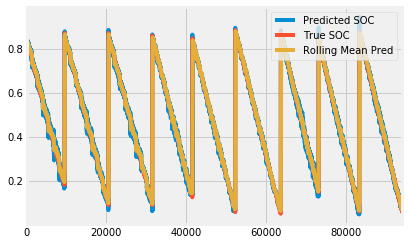

In [11]:
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
R2_scores = []

print("Training Time: {}".format(time.time()-time_start))

print("----------------------------")
prediction = model.predict(trainX)
df = pd.DataFrame(prediction, columns=["Predicted SOC"])
df['True SOC'] = trainY
df['Rolling Mean Pred'] = df["Predicted SOC"].rolling(window = 100).mean()
df = df.dropna()

# Calculate MSE
mseScore = mean_squared_error(df['True SOC'].values, df['Rolling Mean Pred'].values)
print('Train MSE: %.6f  ' % (mseScore))
MSE_scores.append(mseScore)

# Calculate RMSE
rmseScore = math.sqrt(mean_squared_error(df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Train RMSE: %.6f  ' % (rmseScore))
RMSE_scores.append(rmseScore)

# Calculate MAE
maeScore = math.sqrt(mean_absolute_error(df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Train MAE: %.6f  ' % (maeScore))
MAE_scores.append(maeScore)

# Calculate MAPE
mapeScore = math.sqrt(mean_absolute_percentage_error(df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Train MAPE: %.6f  ' % (mapeScore))
MAPE_scores.append(mapeScore)

# Calculate R2
r2score = r2_score(df['True SOC'].values, df['Rolling Mean Pred'].values)  
print('R2 Coefficient: %.6f ' % (r2score))
R2_scores.append(r2score)



df.plot()

----------------------------
Test MSE: 0.005985  
Test RMSE: 0.077365  
Test MAE: 0.248026  
Test MAPE: 5.066465  
R2 Coefficient: 0.875462 


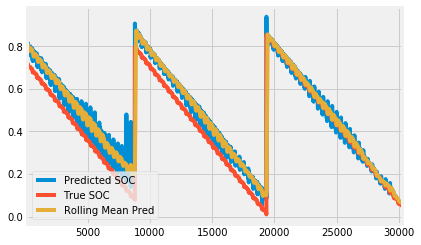

In [12]:
print("----------------------------")
prediction = model.predict(testX)
df = pd.DataFrame(prediction, columns=["Predicted SOC"])
df['True SOC'] = testY
df['Rolling Mean Pred'] = df["Predicted SOC"].rolling(window=100).mean()
df = df.dropna()

# Calculate MSE
mseScore = mean_squared_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values)
print('Test MSE: %.6f  ' % (mseScore))
MSE_scores.append(mseScore)

# Calculate RMSE
rmseScore = math.sqrt(mean_squared_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Test RMSE: %.6f  ' % (rmseScore))
RMSE_scores.append(rmseScore)

# Calculate MAE
maeScore = math.sqrt(mean_absolute_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Test MAE: %.6f  ' % (maeScore))
MAE_scores.append(maeScore)

# Calculate MAPE
mapeScore = math.sqrt(mean_absolute_percentage_error(
    df['True SOC'].values, df['Rolling Mean Pred'].values))
print('Test MAPE: %.6f  ' % (mapeScore))
MAPE_scores.append(mapeScore)

# Calculate R2
r2score = r2_score(df['True SOC'].values, df['Rolling Mean Pred'].values)
print('R2 Coefficient: %.6f ' % (r2score))
R2_scores.append(r2score)


df.plot()

In [13]:
result_df = pd.DataFrame({"Dataset":["Train", "Test"], "MSE":MSE_scores, "RMSE":RMSE_scores, "MAE":MAE_scores, "MAPE":MAPE_scores, "R2":R2_scores})
result_df

,Dataset,MSE,RMSE,MAE,MAPE,R2
0,Train,0.001656,0.040699,0.094224,1.452419,0.966754
1,Test,0.005985,0.077365,0.248026,5.066465,0.875462
